### TIME SERIES
Any set if values recorded periodically over time is known as a time series.\
Time series is an example of Sequential Data and Deep learning specializes is Dealing with such data.<br/>
Example of Sequential Data:
Stock Data, Text, Weather etc.
Weather is a dynamical system . That means even though we have a perfect equation for a particular system , the more we try to predict the future , the more wrong we are.
"Chaos Theory" or "Butterfly Effect"



In [ ]:
# Auto-Regressive Linear Model for Time Series prediction.
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


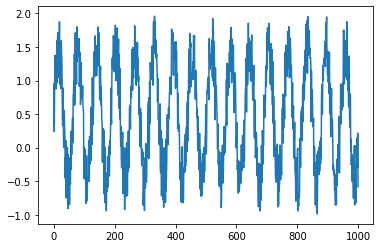

In [ ]:
N=1000
series = np.sin(0.1* np.arange(N))+np.random.rand(N)
plt.plot(series)
plt.show()

In [ ]:
T= 10
X=[]
Y=[]
for i in range(len(series)-T):
  x= series[i:i+T]
  X.append(x)
  y= series[i+T]
  Y.append(y)

X= np.array(X).reshape(-1,T)
Y=np.array(Y).reshape(-1,1)
N= len(X)
print("length of input is",N)
print("X shape", X.shape, "Y Shape", Y.shape)


length of input is 990
X shape (990, 10) Y Shape (990, 1)


In [ ]:
K = list(X)
print(K)

In [ ]:
model = nn.Linear(T,1)

In [ ]:
X_train= torch.from_numpy(X[:N//2].astype(np.float32))
Y_train= torch.from_numpy(Y[:N//2].astype(np.float32))
X_test= torch.from_numpy(X[N//2:].astype(np.float32))
Y_test= torch.from_numpy(Y[N//2:].astype(np.float32))



In [ ]:
criterion = nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(),lr=0.1 )


In [ ]:
def full_gd(model,criterion,optimizer,X_train,X_test, Y_train, Y_test,epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)
  for i in range(epochs):
    optimizer.zero_grad()

    train_outputs= model(X_train)
    loss= criterion(train_outputs,Y_train)

    train_losses[i]=loss.item()

    loss.backward()
    optimizer.step()

    test_outputs= model(X_test)
    test_loss= criterion(test_outputs,Y_test)
    test_losses[i]= test_loss.item()

    if((i+1)%5==0):
      print(f'Epoch {i+1}/{epochs} : Train loss -> {loss.item()}, Test Loss -> {test_loss.item()} ')

  return train_losses,test_losses

train_losses, test_losses = full_gd(model,criterion,optimizer,X_train, X_test, Y_train,Y_test,epochs=200)











Epoch 5/200 : Train loss -> 0.3283894956111908, Test Loss -> 0.2842140793800354 
Epoch 10/200 : Train loss -> 0.22737263143062592, Test Loss -> 0.16430631279945374 
Epoch 15/200 : Train loss -> 0.17864856123924255, Test Loss -> 0.13609030842781067 
Epoch 20/200 : Train loss -> 0.15258902311325073, Test Loss -> 0.12286190688610077 
Epoch 25/200 : Train loss -> 0.13316760957241058, Test Loss -> 0.11290600895881653 
Epoch 30/200 : Train loss -> 0.12137450277805328, Test Loss -> 0.10916853696107864 
Epoch 35/200 : Train loss -> 0.1172109842300415, Test Loss -> 0.10998163372278214 
Epoch 40/200 : Train loss -> 0.1170685812830925, Test Loss -> 0.11055655032396317 
Epoch 45/200 : Train loss -> 0.11732470244169235, Test Loss -> 0.10871065407991409 
Epoch 50/200 : Train loss -> 0.11665897816419601, Test Loss -> 0.106526218354702 
Epoch 55/200 : Train loss -> 0.11560972034931183, Test Loss -> 0.10599423199892044 
Epoch 60/200 : Train loss -> 0.11523569375276566, Test Loss -> 0.10648389160633087 

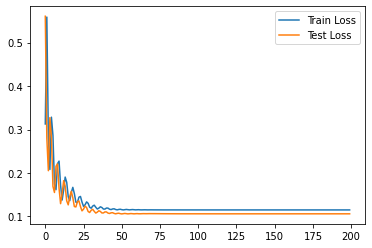

In [ ]:
plt.plot(train_losses,label='Train Loss')
plt.plot(test_losses, label= 'Test Loss')
plt.legend()
plt.show()

In [ ]:
validation_outputs= Y[-N//2:]
predictions=[]

i=0

while (len(predictions)<len(validation_outputs)):
  input_= X_test[i].view(-1,T)
  p= model(input_)[0,0].item()
  i+=1
  predictions.append(p)




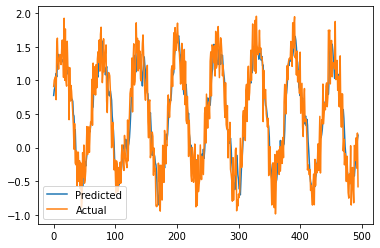

In [ ]:
plt.plot(predictions, label='Predicted')
plt.plot(validation_outputs,label='Actual')
plt.legend()
plt.show()


In [ ]:
# Correct way of forecasting
# We add the newest value to our input_ variable and then predict further using the previously predicted value.

validation_prediction= []
validation_output= Y[-N//2:]

x_last= X_test[0]


while(len(validation_prediction)<len(validation_output)):
  input_= x_last.view(1,-1)
  p= model(input_)

  validation_prediction.append(p[0,0].item())

  x_last = torch.cat((x_last[1:], p[0]))



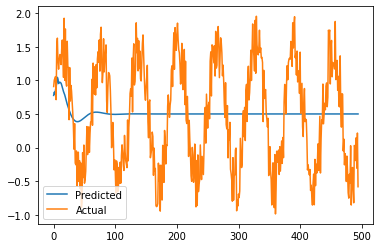

In [ ]:
# Plot
plt.plot(validation_prediction, label='Predicted')
plt.plot(validation_output,label='Actual')
plt.legend()
plt.show()

## Time Series prediction using simple RNN.


In [ ]:
# RNN

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(device)

cpu


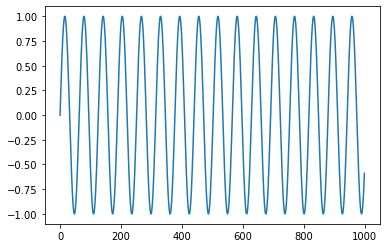

In [ ]:
N=1000
series = np.sin(0.1* np.arange(N))#+np.random.rand(N) --> Keeping the noise for later.
plt.plot(series)
plt.show()

In [ ]:
T=10
X=[]
Y=[]
for i in range(len(series)-T):
  x= series[i:i+T]
  X.append(x)
  y= series[i+T]
  Y.append(y)
X= np.array(X).reshape(-1,T,1)
Y= np.array(Y).reshape(-1,1)
print(X.shape)
print(Y.shape)

(990, 10, 1)
(990, 1)


In [ ]:
class SimpleRNN(nn.Module):
  def __init__(self,n_inputs, n_hidden, n_rnnlayers,n_outputs):
    super(SimpleRNN,self).__init__()
    self.D=n_inputs
    self.M= n_hidden
    self.K=n_outputs
    self.L= n_rnnlayers

    self.rnn= nn.RNN(
        input_size= self.D,
        hidden_size= self.M,
        num_layers= self.L, # Number of RNNs to stack together
        nonlinearity='relu',
        batch_first=True
    )
    self.fc= nn.Linear(self.M,self.K)

# X is a sequence of length N x T x D
  def forward(self,X):
    h0= torch.zeros(self.L , X.size(0), self.M).to(device)

    out ,_= self.rnn(X,h0)

    out= self.fc(out[:,-1,:]) # We only want h(T) at the final time step. So we are going to put -1 on the second dimension.
    return out

In [ ]:
model = SimpleRNN(n_inputs= 1, n_hidden= 5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.1)


In [ ]:
X_train= torch.from_numpy(X[:-N//2].astype(np.float32))
Y_train= torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test= torch.from_numpy(X[-N//2:].astype(np.float32))
Y_test= torch.from_numpy(Y[-N//2:].astype(np.float32))


In [ ]:
X_train,Y_train,X_test,Y_test= X_train.to(device),Y_train.to(device),X_test.to(device),Y_test.to(device)

In [ ]:
def gd(model,criterion,optimizer,X_train,Y_train,X_test,Y_test,epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)
  for i in range(epochs):
    optimizer.zero_grad()

    outputs= model(X_train)
    loss= criterion(outputs,Y_train)

    train_losses[i]= loss

    loss.backward()
    optimizer.step()

    test_output= model(X_test)
    test_loss= criterion(test_output,Y_test)

    test_losses[i]= test_loss

    if((i+1)%5==0):
      print(f'Epoch {i+1}/{epochs} : Train loss -> {loss.item()}, Test Loss -> {test_loss.item()} ')

  return train_losses,test_losses

train_losses,test_losses = gd(model,criterion,optimizer,X_train,Y_train,X_test,Y_test,epochs=200)




Epoch 5/200 : Train loss -> 5.527353278012015e-05, Test Loss -> 5.2857449190923944e-05 
Epoch 10/200 : Train loss -> 5.0073704187525436e-05, Test Loss -> 4.7828565584495664e-05 
Epoch 15/200 : Train loss -> 4.5183933252701536e-05, Test Loss -> 4.314482066547498e-05 
Epoch 20/200 : Train loss -> 4.067814734298736e-05, Test Loss -> 3.872216257150285e-05 
Epoch 25/200 : Train loss -> 3.763916902244091e-05, Test Loss -> 3.793030555243604e-05 
Epoch 30/200 : Train loss -> 0.00016128482820931822, Test Loss -> 0.00037897579022683203 
Epoch 35/200 : Train loss -> 0.014456725679337978, Test Loss -> 0.019286906346678734 
Epoch 40/200 : Train loss -> 0.00034914331627078354, Test Loss -> 0.00585623225197196 
Epoch 45/200 : Train loss -> 0.0023437084164470434, Test Loss -> 0.001316313399001956 
Epoch 50/200 : Train loss -> 0.00023896426137071103, Test Loss -> 0.0017633720999583602 
Epoch 55/200 : Train loss -> 0.0008982910076156259, Test Loss -> 0.0005267451633699238 
Epoch 60/200 : Train loss -> 0

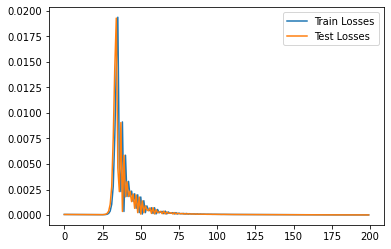

In [ ]:
plt.plot(train_losses, label='Train Losses')
plt.plot(test_losses, label='Test Losses')
plt.legend()
plt.show()



In [ ]:
# One step Prediction
validation_prediction= []
validation_targets= Y[-N//2:]

i=0

while(len(validation_prediction)<len(validation_targets)):
  input= X_test[i].reshape(1,T,1)
  p= model(input)[0,0].item()

  validation_prediction.append(p)
  i+=1



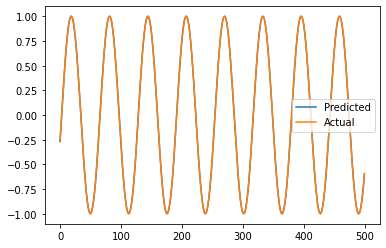

In [ ]:
plt.plot(validation_prediction,label='Predicted')
plt.plot(validation_targets,label='Actual')
plt.legend()
plt.show()


In [ ]:
# Actual way of forecasting.
# Multi-Step Forecast

validation_predictions= []
validation_target=Y[-N//2:]

x_last= X_test[0].reshape(T)

while(len(validation_predictions)<len(validation_target)):
  input= x_last.reshape(1,T,1)
  p= model(input)
  validation_predictions.append(p[0,0].item())
  x_last= torch.concat((x_last[1:], p[0]))




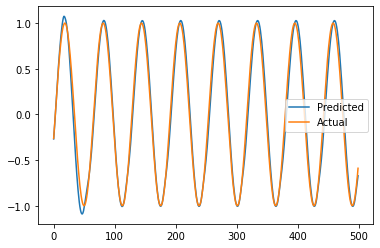

In [ ]:
plt.plot(validation_predictions,label='Predicted')
plt.plot(validation_target,label='Actual')
plt.legend()
plt.show()


In [ ]:
 # GRU

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(device)

cpu


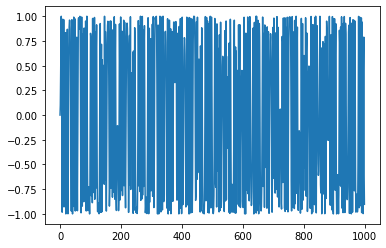

In [ ]:
N=1000
series = np.sin(0.1* np.arange(N)**2)#+np.random.rand(N) --> Keeping the noise for later.
plt.plot(series)
plt.show()

In [ ]:
T=10
X=[]
Y=[]
for i in range(len(series)-T):
  x= series[i:i+T]
  X.append(x)
  y= series[i+T]
  Y.append(y)
X= np.array(X).reshape(-1,T,1)
Y= np.array(Y).reshape(-1,1)
print(X.shape)
print(Y.shape)

(990, 10, 1)
(990, 1)


In [ ]:
class SimpleLSTM(nn.Module):
  def __init__(self,n_inputs, n_hidden,n_rnnlayers,n_outputs):
    super(SimpleLSTM,self).__init__()
    self.D=n_inputs
    self.M= n_hidden
    self.K=n_outputs
    self.L = n_rnnlayers

    self.rnn= nn.LSTM(
        input_size= self.D,
        hidden_size= self.M,
        num_layers= self.L,
        batch_first=True
    )
    self.fc= nn.Linear(self.M,self.K)

# X is a sequence of length N x T x D
  def forward(self,X):
    h0= torch.zeros(self.L , X.size(0), self.M).to(device)
    c0=h0= torch.zeros(self.L , X.size(0), self.M).to(device)

    out ,_= self.rnn(X,(h0,c0))

    out= self.fc(out[:,-1,:]) # We only want h(T) at the final time step. So we are going to put -1 on the second dimension.
    return out

In [ ]:
model = SimpleLSTM(n_inputs= 1, n_hidden= 5,n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleLSTM(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.1)


In [ ]:
X_train= torch.from_numpy(X[:-N//2].astype(np.float32))
Y_train= torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test= torch.from_numpy(X[-N//2:].astype(np.float32))
Y_test= torch.from_numpy(Y[-N//2:].astype(np.float32))


In [ ]:
X_train,Y_train,X_test,Y_test= X_train.to(device),Y_train.to(device),X_test.to(device),Y_test.to(device)

In [ ]:
def gd(model,criterion,optimizer,X_train,Y_train,X_test,Y_test,epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)
  for i in range(epochs):
    optimizer.zero_grad()

    outputs= model(X_train)
    loss= criterion(outputs,Y_train)

    train_losses[i]= loss

    loss.backward()
    optimizer.step()

    test_output= model(X_test)
    test_loss= criterion(test_output,Y_test)

    test_losses[i]= test_loss

    if((i+1)%5==0):
      print(f'Epoch {i+1}/{epochs} : Train loss -> {loss.item()}, Test Loss -> {test_loss.item()} ')

  return train_losses,test_losses

train_losses,test_losses = gd(model,criterion,optimizer,X_train,Y_train,X_test,Y_test,epochs=200)




Epoch 5/200 : Train loss -> 0.5334353446960449, Test Loss -> 0.4917444884777069 
Epoch 10/200 : Train loss -> 0.5314960479736328, Test Loss -> 0.48622918128967285 
Epoch 15/200 : Train loss -> 0.5255454778671265, Test Loss -> 0.48535528779029846 
Epoch 20/200 : Train loss -> 0.49812787771224976, Test Loss -> 0.4606807827949524 
Epoch 25/200 : Train loss -> 0.3966451585292816, Test Loss -> 0.36780494451522827 
Epoch 30/200 : Train loss -> 0.22755610942840576, Test Loss -> 0.21825003623962402 
Epoch 35/200 : Train loss -> 0.2075323760509491, Test Loss -> 0.20230595767498016 
Epoch 40/200 : Train loss -> 0.16293367743492126, Test Loss -> 0.15641550719738007 
Epoch 45/200 : Train loss -> 0.12917117774486542, Test Loss -> 0.1298787146806717 
Epoch 50/200 : Train loss -> 0.0973455011844635, Test Loss -> 0.11542769521474838 
Epoch 55/200 : Train loss -> 0.08055499941110611, Test Loss -> 0.10579008609056473 
Epoch 60/200 : Train loss -> 0.0693601444363594, Test Loss -> 0.10037990659475327 
Epo

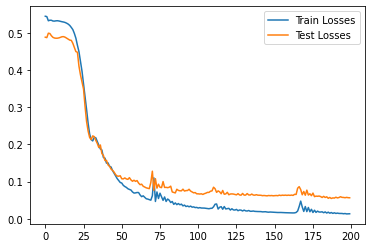

In [ ]:
plt.plot(train_losses, label='Train Losses')
plt.plot(test_losses, label='Test Losses')
plt.legend()
plt.show()




In [ ]:
# One step Prediction
validation_prediction= []
validation_targets= Y[-N//2:]

i=0

while(len(validation_prediction)<len(validation_targets)):
  input= X_test[i].reshape(1,T,1)
  p= model(input)[0,0].item()

  validation_prediction.append(p)
  i+=1


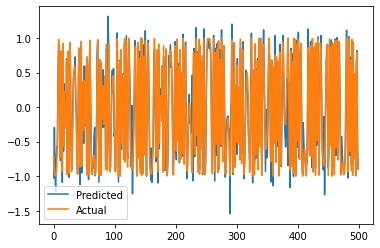

In [ ]:
plt.plot(validation_prediction,label='Predicted')
plt.plot(validation_targets,label='Actual')
plt.legend()
plt.show()


In [ ]:
# Actual way of forecasting.
# Multi-Step Forecast

validation_predictions= []
validation_target=Y[-N//2:]

x_last= X_test[0].reshape(T)

while(len(validation_predictions)<len(validation_target)):
  input= x_last.reshape(1,T,1)
  p= model(input)
  validation_predictions.append(p[0,0].item())
  x_last= torch.concat((x_last[1:], p[0]))




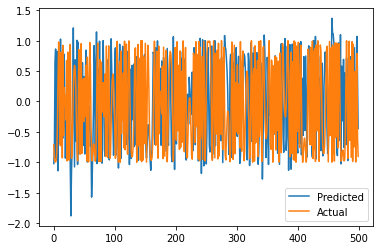

In [ ]:
plt.plot(validation_predictions,label='Predicted')
plt.plot(validation_target,label='Actual')
plt.legend()
plt.show()
